In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import scipy.io
from scipy.sparse import csgraph
from sklearn.metrics.pairwise import pairwise_distances
from scipy.linalg import toeplitz
import matplotlib.colors
import seaborn as sns
from matplotlib import rc

from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score

import os
import sys
from importlib import reload

import filters
import imputation
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot
import spectral

In [2]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}
chromOrder = list(chromDict.values())

In [3]:
filepath = "filtered_data/adjacent1MBfiltered.csv"

adjDf = pd.read_csv(filepath)
adjDf['filterType'] = 'adjacent'

print(f"{adjDf.shape=}")

filepath = "filtered_data/clique1MBfiltered.csv"

cliqDf = pd.read_csv(filepath)
cliqDf['filterType'] = 'expanded'

print(f"{cliqDf.shape=}")

# combine the datasets

df = pd.concat([adjDf, cliqDf], ignore_index=True)
print(f"{df.shape=}")
df['filterType'].value_counts()

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39,45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


adjDf.shape=(286943, 66)


/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


cliqDf.shape=(636130, 66)
df.shape=(923073, 66)


expanded    636130
adjacent    286943
Name: filterType, dtype: int64

[]

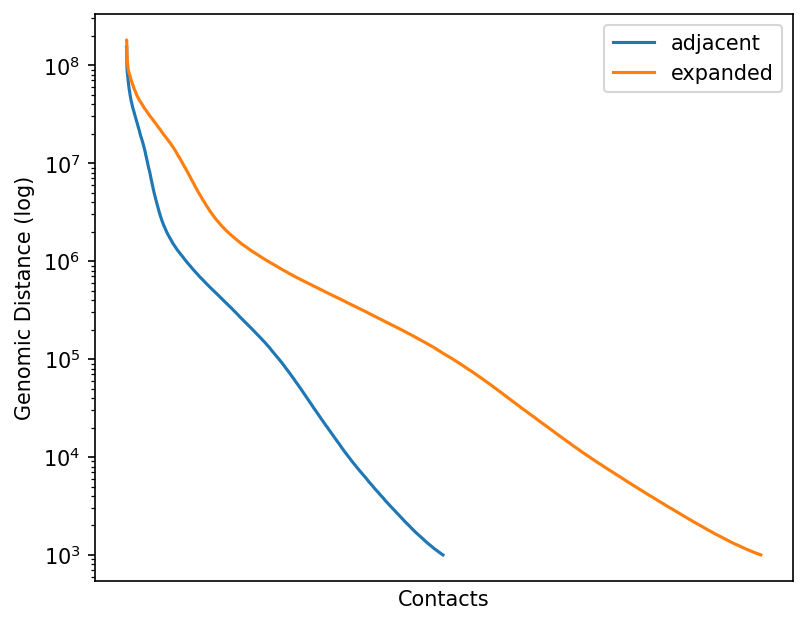

In [30]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 6, 5

threshold = 1000
for i, fType in enumerate(df['filterType'].unique()):
    
    tmp = df[(df['filterType'] == fType)].reset_index(drop=True)
    dists = np.array(sorted(tmp['contact_genome_distance'], reverse=True))
    
    dists = dists[dists > threshold]
    plt.plot(range(len(dists)), dists, label=f"{fType}")

plt.legend()
plt.xlabel('Contacts')
plt.ylabel('Genomic Distance (log)')
plt.yscale('log')

plt.gca().axes.get_xaxis().set_ticks([])



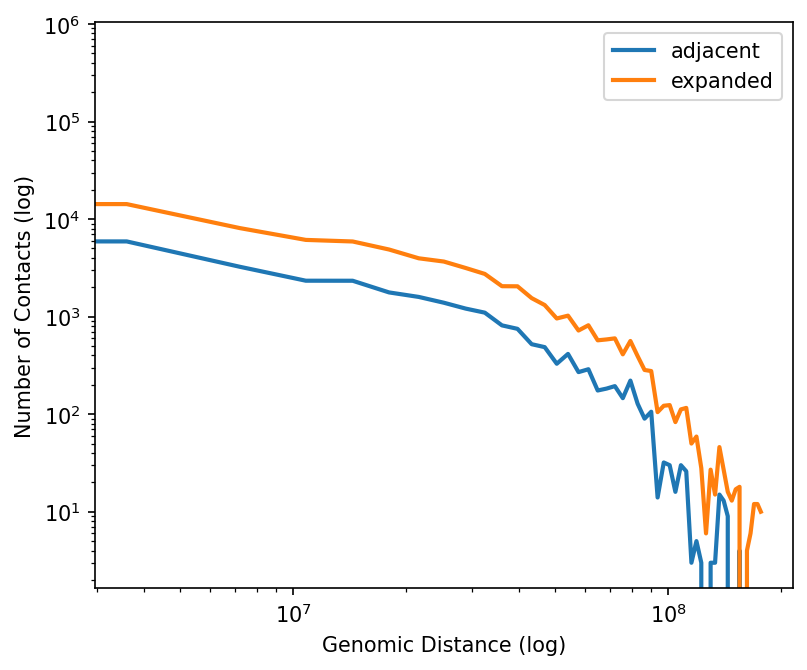

In [31]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 6, 5


nBins = 50
binMin = df['contact_genome_distance'].min()
binMax = df['contact_genome_distance'].max()
histBins = np.linspace(int(binMin), int(binMax), nBins+1)

for i, fType in enumerate(df['filterType'].unique()):
    
    tmp = df[(df['filterType'] == fType)].reset_index(drop=True)
    dists = sorted(tmp['contact_genome_distance'], reverse=True)
    
    counts, binEdges = np.histogram(dists, bins=histBins)
    
    normedCounts = [x/counts.sum() for x in counts]
    
    plt.plot(binEdges[:-1], 
             counts, 
             linewidth=2,
             label=f"{fType}")
    

plt.legend()
plt.xlabel('Genomic Distance (log)')
plt.xscale('log')
plt.ylabel('Number of Contacts (log)')
plt.yscale('log')